In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates

import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib.colors import LogNorm

from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch


from astropy.io import fits



In [2]:
# Assembly task
# https://github.com/lsst/ip_isr/blob/main/python/lsst/ip/isr/isrTask.py

from lsst.ip.isr.assembleCcdTask import (AssembleCcdConfig, AssembleCcdTask)
from lsst.ip.isr.isrTask import (IsrTask, IsrTaskConfig)

#https://github.com/lsst/ip_isr/blob/main/python/lsst/ip/isr/overscan.py
from lsst.ip.isr import  OverscanCorrectionTaskConfig, OverscanCorrectionTask

In [3]:
# LSST Display
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

In [4]:
import warnings
warnings.filterwarnings("ignore")

## Butler 

In [5]:
import lsst.daf.butler as dafButler

In [6]:
embargo = True

In [7]:
if embargo:
    repo="/sdf/group/rubin/repo/oga/"
else:
    repo = "/sdf/group/rubin/repo/main"
butler = dafButler.Butler(repo)
registry = butler.registry

In [8]:
'''
calibCollections = ['LATISS/defaults','LATISS/raw/all']
for col in registry.queryCollections("*LATISS/calib*"):
    calibCollections.append(col)
'''
calibCollections = ['LATISS/calib','LATISS/raw/all']

In [9]:
camera = 'LATISS'
physical_filter = 'collimator~empty'
observation_type = 'flat'

We need to specify if the exposures are raw or super flats (exp_type = 'raw' / 'flat') 

In [10]:
exp_type = 'raw'

In [11]:
#where_flats = "instrument='LATISS' AND physical_filter='empty~empty' AND exposure.observation_type='flat'"
where_flats = "instrument='{0}' AND physical_filter='{1}' AND exposure.observation_type='{2}'".format(camera,physical_filter,observation_type)

In [12]:
flats_records = list(registry.queryDimensionRecords('exposure',where=where_flats))

In [13]:
flats_records[0]

exposure.RecordClass(instrument='LATISS', id=2023091100101, physical_filter='collimator~empty', obs_id='AT_O_20230911_000101', exposure_time=2.0, dark_time=2.23422, observation_type='flat', observation_reason='for_to_test_reduction_code', day_obs=20230911, seq_num=101, seq_start=101, seq_end=101, group_name='2023-09-12T01:07:26.255', group_id=2744104462550000, target_name='FlatField position', science_program='unknown', tracking_ra=286.63299970206987, tracking_dec=-81.20329559315465, sky_angle=None, azimuth=181.76389517118108, zenith_angle=51.03126767555414, has_simulated=False, timespan=Timespan(begin=astropy.time.Time('2023-09-12 01:07:26.630998', scale='tai', format='iso'), end=astropy.time.Time('2023-09-12 01:07:28.865000', scale='tai', format='iso')))

In [14]:
print(len(flats_records))
assert len(flats_records)!=0

6


Select a year for the flats 

In [15]:
flat_year = '2023'

In [16]:
flat_dates = []
for flat_ in flats_records:
    if flat_year in str(flat_.day_obs):
        flat_dates.append(flat_.day_obs)


Available dates for flats of a given year 

In [17]:
flat_dates = np.unique(flat_dates)
print(flat_dates)

[20230911]


### We select a date close to the that of the spectra that we want to deflat: 

In [18]:
flat_date = 20230911

Available flat ids 

In [19]:
flats_selected = []
for flat_ in flats_records:
    if flat_.day_obs==flat_date:
        flats_selected.append(flat_.id)
flats_selected = np.sort(np.array(flats_selected))
print('Flat IDs: ', flats_selected)

Flat IDs:  [2023091100099 2023091100100 2023091100101 2023091100102 2023091100103
 2023091100104]


Check that we can load the flats 

In [20]:
#flat_arrays = []
exp_times = []
for fid_ in flats_selected:
    try:
        flat_img = butler.get(
            exp_type,
            instrument="LATISS", exposure=fid_, detector=0,
            collections=calibCollections)
        #flat_arrays.append(flat_img.getImage().array)
        print('Flat {0} properly loaded'.format(fid_))
        exp_time_ = flat_img.getMetadata().toDict()['EXPTIME']
        exp_times.append(exp_time_)
        print('Exposure time  of exposure {0} = {1}s'.format(fid_,exp_time_))
    except:
        print('Could not load flat {0}'.format(fid_))
print(exp_times)

Flat 2023091100099 properly loaded
Exposure time  of exposure 2023091100099 = 1.0s
Flat 2023091100100 properly loaded
Exposure time  of exposure 2023091100100 = 5.0s
Flat 2023091100101 properly loaded
Exposure time  of exposure 2023091100101 = 2.0s
Flat 2023091100102 properly loaded
Exposure time  of exposure 2023091100102 = 3.0s
Flat 2023091100103 properly loaded
Exposure time  of exposure 2023091100103 = 4.0s
Flat 2023091100104 properly loaded
Exposure time  of exposure 2023091100104 = 6.0s
[1.0, 5.0, 2.0, 3.0, 4.0, 6.0]


In [43]:
plot_flats = True
max_plots = 5

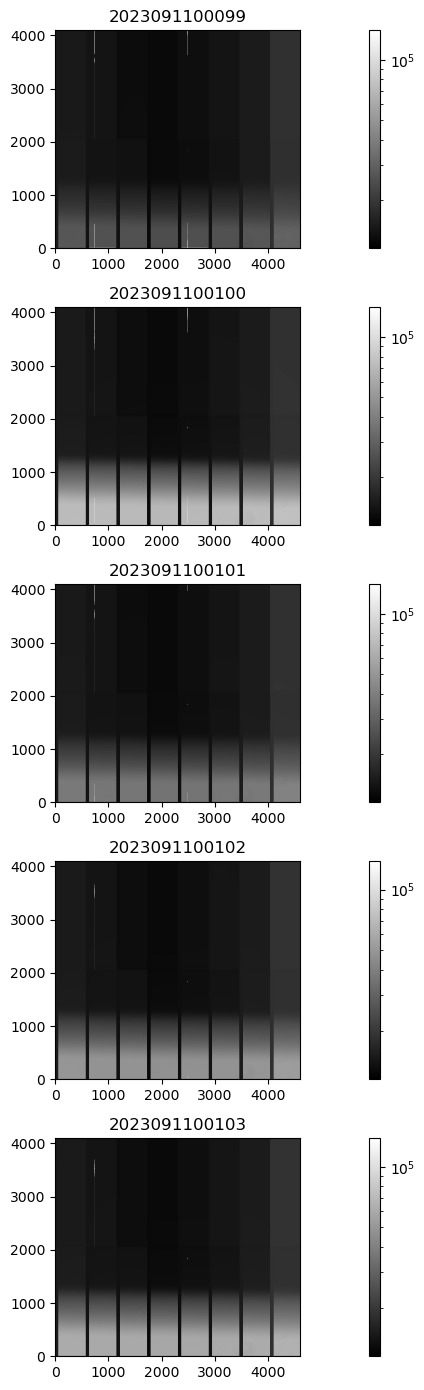

In [45]:
if plot_flats:
    fig = plt.figure(figsize=(14,14))
    for i,fid_ in enumerate(flats_selected):
        if i<max_plots:
            flat_img_ = butler.get(
                exp_type,
                instrument="LATISS", exposure=fid_, detector=0,
                collections=calibCollections)
            data_ = flat_img_.getImage().array
            ax = fig.add_subplot(max_plots,1,i+1)
            im = ax.imshow(data_,cmap="gray",origin='lower',norm=LogNorm())
            ax.set_title(fid_)
            plt.colorbar(im,ax=ax)
    del(flat_img_)
plt.tight_layout()

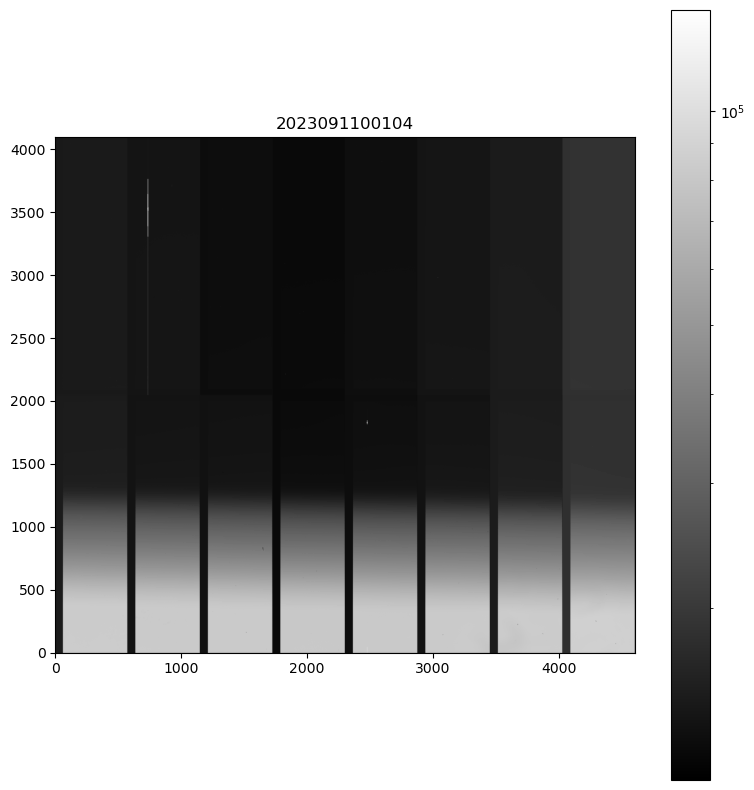

In [46]:
fig = plt.figure(figsize=(8,8))
flat_img_ = butler.get(
                exp_type,
                instrument="LATISS", exposure=flats_selected[-1], detector=0,
                collections=calibCollections)
data_ = flat_img_.getImage().array
ax = fig.add_subplot(111)
im = ax.imshow(data_,cmap="gray",origin='lower',norm=LogNorm())
ax.set_title(flats_selected[-1])
plt.colorbar(im,ax=ax)
plt.tight_layout()
del(flat_img_)